In [1]:
from mohan.Similarity import Similarity
from mohan.ColavSimilarity import parse_doi, parse_string
from mohan.Schemas import openalex_works
from joblib import Parallel, delayed
import pickle
import numpy as np
from mohan.ColavSimilarity import ColavSimilarity, parse_doi, parse_string
from mohan.Schemas import kahi_works
from elasticsearch import Elasticsearch, __version__ as es_version
from sklearn import metrics
import matplotlib.pyplot as plt

In [11]:
class Similarity:
    def __init__(self, es_index, es_uri: str = "http://localhost:9200",
                 es_auth: tuple = ('elastic', 'colav'),
                 es_req_timeout: int = 120, schema=kahi_works):
        """
        Initialize the Similarity class.
        Parameters:
        -----------
        es_index: str 
                name of the index
        es_uri: str 
                uri of the elastic search server
        es_auth: tuple 
                authentication for the elastic search server
        es_req_timeout: int 
                elastic search request timeout
        """
        auth = es_auth
        if es_version[0] < 8:
            self.es = Elasticsearch(
                es_uri, http_auth=auth, timeout=es_req_timeout)
        else:
            self.es = Elasticsearch(
                es_uri, basic_auth=auth, timeout=es_req_timeout)
        self.es_index = es_index
        self.schema = schema

    def create_index(self, mapping: dict = None, recreate: bool = False):
        """
        Create an index.
        Parameters:
        -----------
        index_name: str name of the index
        mapping: dict mapping of the index
        recreate: bool whether to recreate the index or not

        """
        if recreate:
            self.delete_index(self.es_index)
        if mapping:
            self.es.indices.create(index=self.es_index, body=mapping)
        else:
            self.es.indices.create(index=self.es_index)

    def delete_index(self, index_name: str):
        """
        Delete an index.
        Parameters:
        -----------
        index_name: str name of the index
        """
        self.es.indices.delete(index=index_name)

    def insert_work(self, _id: str, work: dict):
        """
        Insert a work into the index.
        Parameters:
        -----------
        _id: str id of the work (ex: mongodb id as string)
        work: dict work to be inserted
        """
        return self.es.index(index=self.es_index,  id=_id, document=work)

    def search_work(self, title: str, authors: str, source: str, year: str,
                    volume: str, issue: str, page_start: str, page_end: str,
                    ratio_thold: int = 90, partial_thold: int = 95, low_thold: int = 80):
        """
        Compare two papers to know if they are the same or not.
        Parameters:
        -----------
        title: str 
                title of the paper
        authors: str 
                authors of the paper
        source: str 
                name of the journal in which the paper was published
        year: int 
                year in which the paper was published
        volume: int 
                volume of the journal in which the paper was published
        issue: int 
                issue of the journal in which the paper was published
        page_start: int 
                first page of the paper
        page_end: int 
                last page of the paper
        ratio_thold: int 
                threshold to compare through ratio function in thefuzz library
        partial_ratio_thold: int 
                threshold to compare through partial_ratio function in thefuzz library
        low_thold: int 
            threshold to discard some results with lower score values
        es_request_timeout: int elastic search request timeout

        Returns:
        --------
        record: dict when the papers are (potentially) the same, None otherwise.
        """
        if not isinstance(title, str):
            title = ""

        if not isinstance(source, str):
            source = ""

        if isinstance(volume, int):
            volume = str(volume)

        if isinstance(issue, int):
            issue = str(issue)

        if isinstance(page_start, int):
            page_start = str(page_start)

        if isinstance(page_end, int):
            page_end = str(page_end)

        if not isinstance(volume, str):
            volume = ""

        if not isinstance(issue, str):
            issue = ""

        if not isinstance(page_start, str):
            page_start = ""

        if not isinstance(page_end, str):
            page_end = ""

        body = {
            "query": {
                "bool": {
                    "should": [
                        {"match": {self.schema["title"]: title}},
                        # se tienen que truncar los autores
                        {"match": {self.schema["authors"]: authors[0:100]}},
                        {"match": {self.schema["source"]: source}},
                        {"term":  {self.schema["year"]: year}},
                        {"term":  {self.schema["volume"]: volume}},
                        {"term":  {self.schema["issue"]: issue}},
                        {"term":  {self.schema["page_start"]: page_start}},
                        {"term":  {self.schema["page_end"]: page_end}},
                    ],
                }
            },
            "size": 10,
        }

        res = self.es.search(index=self.es_index, **body)
        if res["hits"]["total"]["value"] != 0:
            for i in res["hits"]["hits"][0:1]:
                title2 = i["_source"]
                for j in self.schema["title"].split("."):
                    title2 = title2[j]
                source2 = i["_source"]
                for j in self.schema["source"].split("."):
                    source2 = source2[j]
                year2 = i["_source"]
                for j in self.schema["year"].split("."):
                    year2 = year2[j]

                value = ColavSimilarity(title, title2,
                                        source, source2,
                                        year, year2,
                                        ratio_thold=ratio_thold, partial_thold=partial_thold, low_thold=low_thold)
                if value:
                    return i
            return None
        else:
            return None


In [12]:
s = Similarity("openalex_parsed",schema = openalex_works)

In [13]:
# open a file, where you stored the pickled data
file = open('dataset_full.pkl', 'rb')
# dump information to that file
data = pickle.load(file)
# close the file
file.close()

In [17]:
fns = []
fps = []

In [19]:
for i in range(100):
    if i%10 == 0:
        print(i)
    scopus = []
    np.random.shuffle(data["p"])
    np.random.shuffle(data["n"])
    for i in data["p"][0:3000]:
        scopus.append((i,True))
    for i in data["n"][0:3000]:
        scopus.append((i,False))
    np.random.shuffle(scopus) #shuffle is inplace
    results = Parallel(n_jobs=64,backend='threading',verbose=1)(delayed(s.search_work)(rec[0]['Title'],rec[0]['Authors'],rec[0]['Source title'],rec[0]['Year'],
                     rec[0]['Volume'], rec[0]['Issue'], rec[0]['Page start'], rec[0]['Page end'],
                     ratio_thold = 90, partial_thold = 95, low_thold = 80) for rec in scopus)
    actual = []
    predicted = []
    for i in range(len(results)):
        actual.append(scopus[i][1])
        if results[i] is not None:
            predicted.append(True)
        else:
            predicted.append(False)
    confusion_matrix = metrics.confusion_matrix(actual, predicted)
    confusion_matrix = np.flip(confusion_matrix)
    fn = confusion_matrix[0][1]*100/(confusion_matrix[0][0]+confusion_matrix[0][1])
    fns.append(fn)
    fp = confusion_matrix[1][0]*100/(confusion_matrix[1][0]+confusion_matrix[1][1])
    fps.append(fp)

0


[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.5s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    3.7s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    7.7s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:   12.0s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:   17.9s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:   23.7s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:   31.0s
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:   37.9s
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:   48.8s
[Parallel(n_jobs=64)]: Done 6000 out of 6000 | elapsed:  1.0min finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.4s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    3.5s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    6.2s
[Parallel(n_j

10


[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    1.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    3.6s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    6.6s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:   12.1s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:   18.9s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:   24.8s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:   31.1s
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:   39.7s
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:   49.5s
[Parallel(n_jobs=64)]: Done 6000 out of 6000 | elapsed:  1.0min finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.5s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    3.7s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    7.9s
[Parallel(n_j

20


[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.7s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    3.2s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    6.5s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:   11.5s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:   16.8s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:   23.8s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:   29.9s
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:   38.9s
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:   47.5s
[Parallel(n_jobs=64)]: Done 6000 out of 6000 | elapsed:   58.6s finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    1.0s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    3.0s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    6.9s
[Parallel(n_j

30


[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.7s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    3.1s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    8.1s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:   11.7s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:   17.6s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:   23.9s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:   32.2s
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:   41.0s
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:   50.6s
[Parallel(n_jobs=64)]: Done 6000 out of 6000 | elapsed:  1.0min finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.5s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    2.4s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    7.4s
[Parallel(n_j

40


[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.9s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    3.6s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    7.1s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:   11.9s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:   19.1s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:   27.2s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:   36.5s
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:   44.5s
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:   54.1s
[Parallel(n_jobs=64)]: Done 6000 out of 6000 | elapsed:  1.1min finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.8s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    3.3s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    6.0s
[Parallel(n_j

50


[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    1.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    3.8s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    8.4s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:   12.5s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:   18.0s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:   25.6s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:   34.5s
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:   41.9s
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:   51.2s
[Parallel(n_jobs=64)]: Done 6000 out of 6000 | elapsed:  1.0min finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.5s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    3.5s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    6.8s
[Parallel(n_j

60


[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.5s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    4.4s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    9.4s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:   14.2s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:   19.7s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:   25.8s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:   34.4s
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:   45.0s
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:   55.6s
[Parallel(n_jobs=64)]: Done 6000 out of 6000 | elapsed:  1.1min finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    1.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    3.8s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    7.4s
[Parallel(n_j

70


[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.7s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    3.7s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    7.9s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:   12.5s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:   19.6s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:   27.1s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:   36.4s
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:   47.5s
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:   55.4s
[Parallel(n_jobs=64)]: Done 6000 out of 6000 | elapsed:  1.1min finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.4s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    3.1s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    8.0s
[Parallel(n_j

80


[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.6s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    3.8s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    8.3s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:   13.5s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:   20.2s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:   28.4s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:   36.6s
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:   46.2s
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:   55.5s
[Parallel(n_jobs=64)]: Done 6000 out of 6000 | elapsed:  1.1min finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    1.1s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    4.1s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    7.6s
[Parallel(n_j

90


[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.5s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    3.0s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    7.4s
[Parallel(n_jobs=64)]: Done 1122 tasks      | elapsed:   11.8s
[Parallel(n_jobs=64)]: Done 1672 tasks      | elapsed:   16.9s
[Parallel(n_jobs=64)]: Done 2322 tasks      | elapsed:   24.2s
[Parallel(n_jobs=64)]: Done 3072 tasks      | elapsed:   31.9s
[Parallel(n_jobs=64)]: Done 3922 tasks      | elapsed:   40.2s
[Parallel(n_jobs=64)]: Done 4872 tasks      | elapsed:   49.4s
[Parallel(n_jobs=64)]: Done 6000 out of 6000 | elapsed:  1.0min finished
[Parallel(n_jobs=64)]: Using backend ThreadingBackend with 64 concurrent workers.
[Parallel(n_jobs=64)]: Done  72 tasks      | elapsed:    0.5s
[Parallel(n_jobs=64)]: Done 322 tasks      | elapsed:    3.3s
[Parallel(n_jobs=64)]: Done 672 tasks      | elapsed:    7.1s
[Parallel(n_j

True

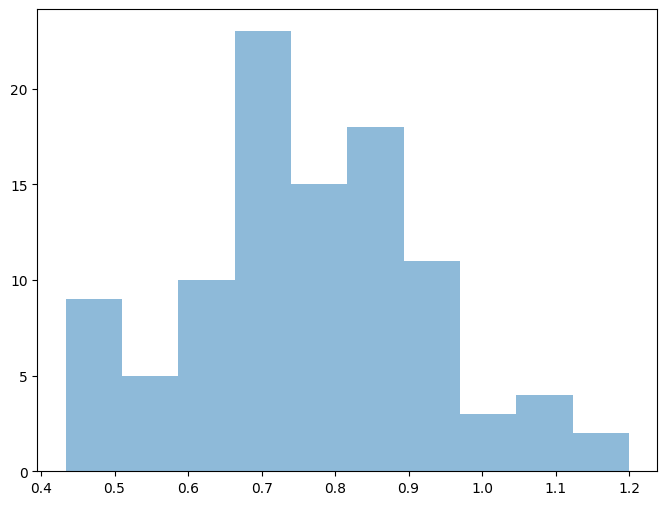

In [24]:
plt.figure(figsize=(8,6))
plt.hist(fns, bins=10, alpha=0.5, label="data1", density=False)
True

True

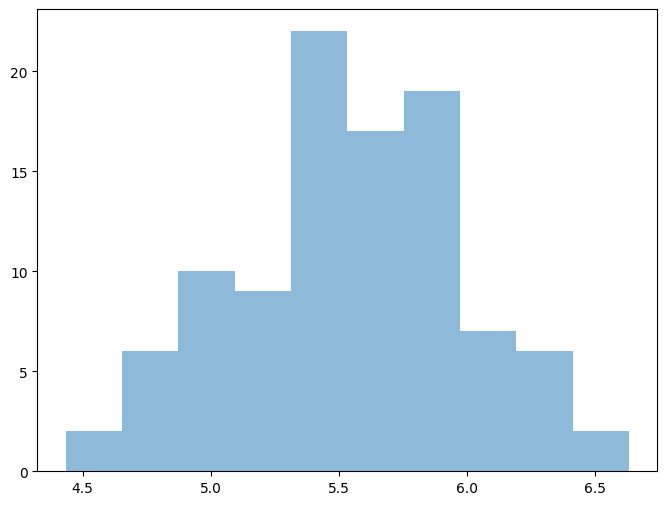

In [27]:
plt.figure(figsize=(8,6))
plt.hist(fps, bins=10, alpha=0.5, label="data1", density=False)
True

In [25]:
np.mean(fns)

0.7616666666666667

In [29]:
np.std(fns)

0.16735690405039566

In [26]:
with open('similarity_fns_fps.pkl', 'wb') as f:
    pickle.dump({"fns":fns,"fps":fps}, f)